# Ling 380 - Week 11

# Processing survey data

Survey answers are typically of the style below, with a very specific question and a [Likert scale](https://en.wikipedia.org/wiki/Likert_scale) that forces the answers into clearly defined categories.

<figure>
    <img src="./img/Likert.png" style="width:450px;"
         alt="supervised classification">
</figure>



This is easy to process, as the answers can be tabulated. Some surveys, however, allow free-text answers. This is the case in the type of question you get at the end of a survey, something like "Anything else you'd like to tell us?". It's also common in focus groups and submissions in public consultation processes. These can go from one-word answers and short sentences to long paragraphs. That's the type of unstructured data that you need text analysis for!

There are many ways we can analyze and summarize the information. we'll focus on:

* Visualization with word clouds
* NER recognition
* Redaction

## Data

There are many public surveys and sources of data (see at the end for more links). Here, we will work with the [Democracy Checkup](https://odesi.ca/en/details?id=/odesi/doi__10-5683_SP3_TEKM3T.xml) distributed by [Odesi](https://odesi.ca/en), a Canadian consortium that holds social science data. This is a survey of Canadian attitudes about democratic values, public policies, and current issues: 

* Harell, Allison; Stephenson, B. Laura; Rubenson, Daniel; Loewen, Peter John, 2023, "Democracy Checkup, 2022. Canada", https://doi.org/10.5683/SP3/TEKM3T, Borealis, V1, UNF:6:ufqbMikbXcaHqVhbaEXR3w== (fileUNF)

The data contains many different variables, most of them numeric or on a scale with fixed values to choose from. But some of the values are free-form text answers; we'll study those.

## Import statements

In [1]:
# run this only once, to install wordcloud

!pip install wordcloud

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy import displacy

## Import and examine the data

The data is huge: 9,829 rows (answers) and 501 questions (columns). As you can see from the output of `df.head()`, most of the data is numerical, so we'll work only with text columns. Luckily, those columns always end with the string "TEXT", so we can use pandas to extract them. For instance: 

* dc22_vote_choice_6_TEXT -- what party the person intends to vote for (in Dec 2022)
* dc22_soc_media_use_9_TEXT -- what social media the person uses
* dc22_language_3_TEXT -- what language the person speaks
* etc.

You can use the [Data explorer](https://borealisdata.ca/data-explorer/?siteUrl=https:%2F%2Fborealisdata.ca&dvLocale=en&fileId=659110) for this dataset to check the actual questions for each of these columns. 

In [3]:
df = pd.read_csv('./data/cora-cdem-2022_F1.csv', encoding = 'utf-8')

/var/folders/wz/znms9m4s22s58bm3g8k29fd40000gn/T/ipykernel_18649/4286278608.py:1: DtypeWarning: Columns (42,162,183) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/cora-cdem-2022_F1.csv', encoding = 'utf-8')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9829 entries, 0 to 9828
Columns: 501 entries, StartDate to dc22_quota_weight
dtypes: float64(230), int64(235), object(36)
memory usage: 37.6+ MB


In [5]:
df.head()

,StartDate,EndDate,Duration__in_seconds_,time,RecordedDate,ResponseId,UserLanguage,survey_wave,dc22_consent_t_First_Click,dc22_consent_t_Last_Click,...,FL_59_DO_Participation2,FL_307_DO_Feminismmodule_attitud,FL_307_DO_Feminismmodule_attitu0,FL_307_DO_Feminismmodule_genderg,Attitudes1_politicianattitudes_D,Attitudes1_politicianattitudes_0,feduid,fedname,pccf_problem,dc22_quota_weight
0,2022-05-10,2022-05-10,954,15.900000,2022-05-10,R_00PSowpHejLqKkN,EN,0,2.888,2.888,...,2,NaN,NaN,NaN,NaN,1.0,35096,Scarborough North / Scarborough-Nord,NaN,1.423473
1,2022-05-15,2022-05-15,634,10.566667,2022-05-15,R_00VQRL4tWUjAZmF,EN,0,1.409,4.597,...,3,NaN,NaN,NaN,1.0,NaN,35051,London--Fanshawe,NaN,1.045923
2,2022-05-08,2022-05-08,827,13.783334,2022-05-08,R_00VXF28obYi9pVT,FR-CA,1,2.374,5.334,...,3,NaN,NaN,NaN,1.0,NaN,24015,Bourassa,NaN,0.584379
3,2022-05-12,2022-05-13,1257,20.950001,2022-05-13,R_00wdiUEEZtW4hWh,EN,0,79.501,81.449,...,3,NaN,NaN,NaN,1.0,NaN,59035,Vancouver East / Vancouver-Est,NaN,1.446689
4,2022-05-09,2022-05-09,914,15.233334,2022-05-09,R_01HAWiwkLRFthTz,EN,0,1.608,3.744,...,1,NaN,NaN,NaN,1.0,NaN,12006,Halifax West / Halifax-Ouest,1.0,1.476455


In [6]:
# check which columns contain the word "TEXT" using a regular expression

print(df.filter(regex='TEXT').columns)

Index(['dc22_genderid_4_TEXT', 'dc22_vote_choice_6_TEXT',
       'dc22_provvote_14_TEXT', 'dc22_feedback_screen_6_TEXT',
       'dc22_feedback_recent_21_TEXT', 'dc22_cc2_4_TEXT',
       'dc22_soc_media_use_9_TEXT', 'dc22_party_id_6_TEXT',
       'dc22_vote_2021_6_TEXT', 'dc22_language_3_TEXT', 'dc22_vismin_13_TEXT',
       'dc22_employment_12_TEXT', 'dc22_disabilitytype_6_TEXT',
       'dc22_religion_22_TEXT'],
      dtype='object')


In [7]:
# create a new dataframe, 'df_text' that contains only those columns

df_text = df.filter(regex='TEXT')

In [8]:
df_text

,dc22_genderid_4_TEXT,dc22_vote_choice_6_TEXT,dc22_provvote_14_TEXT,dc22_feedback_screen_6_TEXT,dc22_feedback_recent_21_TEXT,dc22_cc2_4_TEXT,dc22_soc_media_use_9_TEXT,dc22_party_id_6_TEXT,dc22_vote_2021_6_TEXT,dc22_language_3_TEXT,dc22_vismin_13_TEXT,dc22_employment_12_TEXT,dc22_disabilitytype_6_TEXT,dc22_religion_22_TEXT
0,-99,-99,-99,-99,NaN,-99,-99,-99,NaN,-99,-99,-99,NaN,-99
1,-99,-99,-99,-99,NaN,-99,-99,-99,-99,-99,-99,-99,NaN,-99
2,-99,-99,-99,NaN,NaN,-99,-99,-99,-99,-99,-99,-99,NaN,-99
3,-99,-99,Aaron Gunn,-99,NaN,-99,-99,-99,-99,-99,-99,-99,NaN,Agnostic
4,-99,-99,-99,-99,NaN,-99,-99,-99,NaN,-99,-99,-99,NaN,-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9824,-99,-99,-99,-99,NaN,human activity does not affect climate,NaN,-99,-99,-99,none,-99,NaN,-99
9825,-99,-99,-99,NaN,NaN,-99,-99,-99,-99,-99,-99,-99,NaN,-99
9826,-99,-99,-99,NaN,NaN,-99,-99,-99,-99,-99,-99,-99,NaN,-99
9827,-99,-99,-99,NaN,NaN,-99,-99,-99,-99,italien,-99,-99,NaN,-99


## Working with one column

We will work with one of the columns, 'dc22_vote_choice_6_TEXT', where the question was: "If a federal election were held today, which party would you be most likely to vote for?" 

We will first extract data from that column to a pandas series. When extracting, we will drop any empty values (NaN) with `dropna()` and the columns that contain '-99', which means the person did not answer this question.

Then, we put that into a string variable and lowercase it (so that "People's Party" and "People's party" are considered the same). But then we realize actually that the word "party" occurs here a lot, so we'll simply remove it with the stopwords. 

Finally, we have a somewhat clean string of words that we can send to WordCloud to visualize.

In [9]:
# most of the values are '-99' (unanswered)
# but you can sort other values to find the most frequent in a column

df_text['dc22_vote_choice_6_TEXT'].value_counts()[:20].sort_values(ascending=False)

dc22_vote_choice_6_TEXT
-99                          9102
PPC                            52
Undecided                      27
undecided                      15
People's Party of Canada       13
People's Party                 11
Not sure                        9
Ppc                             9
Unsure                          9
Maverick                        6
Peoples Party                   5
Independent                     5
UNDECIDED                       4
Parti populaire du Canada       4
People's party                  4
not sure                        4
Parti Populaire du Canada       4
Peoples Party of Canada         4
unsure                          4
Je ne sais pas                  4
Name: count, dtype: int64

In [10]:
vote_choice = df_text['dc22_vote_choice_6_TEXT'].dropna().loc[df_text['dc22_vote_choice_6_TEXT'].str.contains('99') == False]

In [11]:
vote_choice

13      Any but Liberals or NDP
21                          NDP
30              Je ne sais pas.
73                          PPC
119                         PPC
                 ...           
9658                  undecided
9668                        PPC
9674          The Peoples party
9811                        PPC
9819         Refuse de répondre
Name: dc22_vote_choice_6_TEXT, Length: 419, dtype: object

In [12]:
# this is a pandas series, so we'll convert it to a string
type(vote_choice)

pandas.core.series.Series

In [13]:
vote_choice_str = ', '.join(vote_choice.astype(str))

In [14]:
vote_choice_str

'Any but Liberals or NDP, NDP, Je ne sais pas., PPC, PPC, Ontario Party, Parti populaire du Canada, Peoples Party of Canada, wildrose, PEOPLE\'S PARTY OF CANADA, Undecided, People\'s party, I honestly dont know, Indécision, Uncertain, Undecided, A Party that I prefer, cancel my vote, Don\'t vote party, vote the candidate, People\'s Party of Canada, Maverick, PPC, aucun, Peoples Party of Canada, They are all the same, People’s Party of Canada, Undecided, Peoples, I dont disclose my voting preference, undecided, Don\'t know, NOT SURE, Who are the candidates in my riding, No idea, PPC, PPC, Parti populaire du Canada, Undecided, PPC, PPC, PPC, western sepratist, Ppc, Libertarian, Not sure, People\'s party, PPC, caq, undecided, Annulation, I, Undecided, People\'s Party of Canada, PPC, Peoples’ Party of Canada, Undecided, Je ne sais pas, Je ne sais pas, CPP, Not Sure, unsure, None of the above, I don’t know, We\'ll see, New Blue, ppc, Parti Populaire du Canada, undecided, Independent, People

In [15]:
# check the contents of stop_words

stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [16]:
# append the word "party"

stop_words.append('party')
stop_words.append('Canada')


In [17]:
# define a function that: 1. tokenizes, 2. lowercases and
# 3. removes stopwords

def clean_text(text):
    words = word_tokenize(text.lower())
    cleaned_words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned_words)

In [18]:
vote_choice_clean = clean_text(vote_choice_str)

In [19]:
vote_choice_clean

'liberals ndp ndp je ne sais ppc ppc ontario parti populaire du canada peoples canada wildrose people canada undecided people honestly dont know indécision uncertain undecided prefer cancel vote vote vote candidate people canada maverick ppc aucun peoples canada people canada undecided peoples dont disclose voting preference undecided know sure candidates riding idea ppc ppc parti populaire du canada undecided ppc ppc ppc western sepratist ppc libertarian sure people ppc caq undecided annulation undecided people canada ppc peoples canada undecided je ne sais pas je ne sais pas cpp sure unsure none know see new blue ppc parti populaire du canada undecided independent people ppc undecided ppc ppc sire ne sais pas sure maveric independent indécise undecided people canada parties suck parti populaire du canada partie populaire québec solidaire undecided peoples canada undecided ppc people canada none annuler mon vote maverick decision unsure undecided maverick je pas à décider sure coaliti

## Get frequencies

You'll see below that WordCloud randomizes the font size of the output. But sometimes we want that to be meaningful, reflecting how frequent the word is. To get that information, we will use NLTK's FreqDist and generate a dictionary when we clean the text.

In [20]:
# define a function that: 1. tokenizes, 2. lowercases,
# 3. removes stopwords and 4. counts the words

def clean_text_freq(text):
    words = word_tokenize(text.lower())
    cleaned_words = [word for word in words if word.isalpha() and word not in stop_words]
    freq_dist = FreqDist(cleaned_words)
    return freq_dist

In [21]:
vote_choice_dict = clean_text_freq(vote_choice_str)

In [22]:
vote_choice_dict

FreqDist({'ppc': 66, 'undecided': 52, 'people': 41, 'canada': 39, 'sure': 27, 'vote': 20, 'pas': 20, 'parti': 19, 'je': 18, 'peoples': 18, ...})

## Word clouds
Word clouds are popular and can look very cool in a report. They can also be misleading if the size of the font does not correspond to the frequency of the word in the data, so you should use them with caution.  

We'll use the [Wordcloud](https://github.com/amueller/word_cloud/) library, which we imported above. There are many options for how to do this. Here are two possibilities, changing the shape and the background colour. Check out the [example gallery](https://amueller.github.io/word_cloud/auto_examples/index.html#example-gallery) for more.

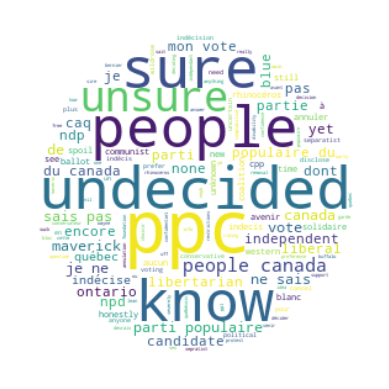

In [23]:
# options
x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# this actually generates the word cloud
wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(vote_choice_clean)

# and this displays it
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

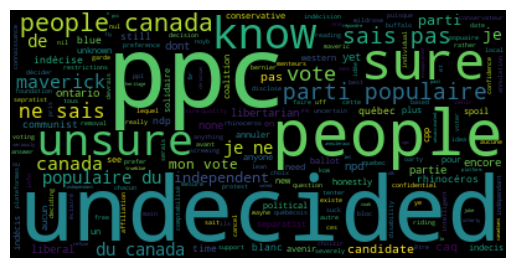

In [24]:
wordcloud = WordCloud().generate(vote_choice_clean)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()#

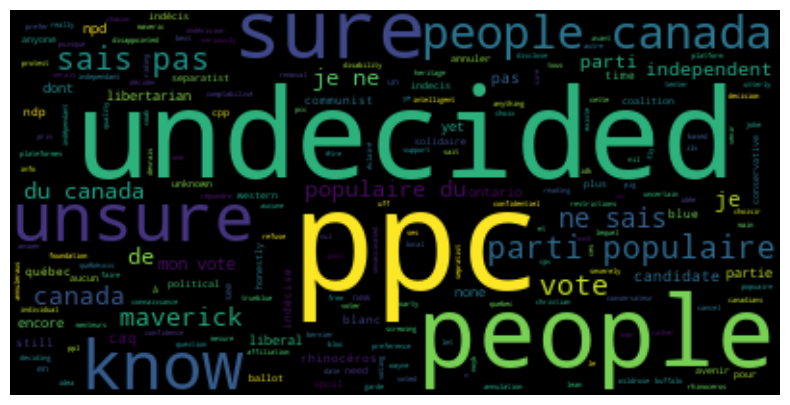

In [25]:
#bigger
wordcloud = WordCloud().generate(vote_choice_clean)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## With the frequency dictionary
Recall that above we created a dictionary of the frequency of each word. We can use it to display relative to frequency.

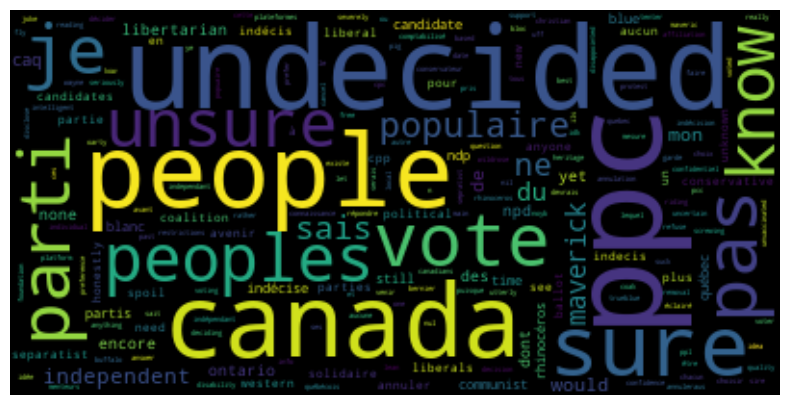

In [26]:
wordcloud = WordCloud().generate_from_frequencies(vote_choice_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Named entities

Another thing you may want to do with survey results is extract the named entities mentioned in the text. Remember that we can do this with spaCy (see Week6). 

We will use the variable `vote_choice_str` from earlier, which is simply the running text of the column about vote choice. We process it with spaCy (which was imported at the top) and we can print the entities that are of type 'ORG', which should correspond to a political party. 

In [27]:
vote_choice_doc = nlp(vote_choice_str)

In [28]:
vote_choice_str

'Any but Liberals or NDP, NDP, Je ne sais pas., PPC, PPC, Ontario Party, Parti populaire du Canada, Peoples Party of Canada, wildrose, PEOPLE\'S PARTY OF CANADA, Undecided, People\'s party, I honestly dont know, Indécision, Uncertain, Undecided, A Party that I prefer, cancel my vote, Don\'t vote party, vote the candidate, People\'s Party of Canada, Maverick, PPC, aucun, Peoples Party of Canada, They are all the same, People’s Party of Canada, Undecided, Peoples, I dont disclose my voting preference, undecided, Don\'t know, NOT SURE, Who are the candidates in my riding, No idea, PPC, PPC, Parti populaire du Canada, Undecided, PPC, PPC, PPC, western sepratist, Ppc, Libertarian, Not sure, People\'s party, PPC, caq, undecided, Annulation, I, Undecided, People\'s Party of Canada, PPC, Peoples’ Party of Canada, Undecided, Je ne sais pas, Je ne sais pas, CPP, Not Sure, unsure, None of the above, I don’t know, We\'ll see, New Blue, ppc, Parti Populaire du Canada, undecided, Independent, People

In [29]:
# print all entities and their label
# note that there are errors here

for ent in vote_choice_doc.ents:
    print(ent.text, ent.label_)

Liberals NORP
NDP ORG
NDP ORG
Je ne sais pas. PERSON
PPC ORG
PPC ORG
Ontario Party ORG
Parti ORG
Canada GPE
Peoples Party of Canada ORG
PEOPLE'S PARTY OF CANADA ORG
Undecided ORG
People's ORG
Indécision ORG
Undecided ORG
Party ORG
People's Party of Canada ORG
Maverick GPE
PPC ORG
aucun, ORG
Peoples Party of Canada ORG
People’s Party of Canada ORG
Undecided, Peoples ORG
PPC ORG
PPC ORG
Parti ORG
Canada GPE
Undecided ORG
PPC ORG
PPC ORG
PPC ORG
People's party ORG
PPC ORG
Undecided ORG
People's Party of Canada ORG
PPC ORG
Peoples’ Party of Canada ORG
Undecided ORG
Je ne sais pas PERSON
Je ne sais pas ORG
CPP ORG
New Blue GPE
Parti Populaire du Canada ORG
Independent ORG
People's Party ORG
PPC ORG
PPC ORG
sais pas ORG
Maveric, Independent ORG
Indécise ORG
Undecided ORG
People's Party of Canada ORG
Parti Populaire du Canada ORG
Québec ORG
Undecided, Peoples Party of Canada ORG
Undecided ORG
PPC ORG
People’s Party of Canada ORG
Maverick GPE
Unsure ORG
Maverick GPE
Je n'arrive ORG
Québec, Ppc

In [30]:
# print the ORG entities

for ent in vote_choice_doc.ents:
    if ent.label_ == "ORG":
        print(ent.text)

NDP
NDP
PPC
PPC
Ontario Party
Parti
Peoples Party of Canada
PEOPLE'S PARTY OF CANADA
Undecided
People's
Indécision
Undecided
Party
People's Party of Canada
PPC
aucun,
Peoples Party of Canada
People’s Party of Canada
Undecided, Peoples
PPC
PPC
Parti
Undecided
PPC
PPC
PPC
People's party
PPC
Undecided
People's Party of Canada
PPC
Peoples’ Party of Canada
Undecided
Je ne sais pas
CPP
Parti Populaire du Canada
Independent
People's Party
PPC
PPC
sais pas
Maveric, Independent
Indécise
Undecided
People's Party of Canada
Parti Populaire du Canada
Québec
Undecided, Peoples Party of Canada
Undecided
PPC
People’s Party of Canada
Unsure
Je n'arrive
Québec, Ppc
Undecided
PPC
PPC
Undecided
Rhinocéros
Undecided
People's Party
PPC
Undecided
UFF
People's Party of Canada
NIL
PPC
Unsure
Parti
Conservateur
Blue Party
NPD
Communist Party
UNDECIDED
Unsure
Maverick Party
Parti Populaire du Canada
People's Party
NONE
Independent
PPC
The Wayne Foundation
PEOPLES PARTY
People's
Ne
Indépendant, People's Party of 

# Redacting documents

This idea comes from an [NLP notebook on redacting names](https://github.com/Jcharis/Natural-Language-Processing-Tutorials/blob/master/NLP_with_SpaCy/Automatic%20Redaction%20%20%26%20Sanitization%20of%20Document%20Using%20Spacy%20NER.ipynb). Once you have named entities identified (hopefully accurately), you can also use the NER output to redact any personal information. For instance, you can identify all the person's names and remove them or replace them with something like 'REDACTED'. 

In [31]:
def sanitize_names(text):
    doc = nlp(text)
    redacted_sentences = []
    
    for token in doc:
        if token.ent_type_ == 'PERSON':
            redacted_sentences.append("[REDACTED]")
        else:
            redacted_sentences.append(token.text)
    
    return ' '.join(redacted_sentences)

In [32]:
vote_choice_redacted = sanitize_names(vote_choice_str)

In [33]:
vote_choice_redacted

'Any but Liberals or NDP , NDP , [REDACTED] [REDACTED] [REDACTED] [REDACTED] [REDACTED] , PPC , PPC , Ontario Party , Parti populaire du Canada , Peoples Party of Canada , wildrose , PEOPLE \'S PARTY OF CANADA , Undecided , People \'s party , I honestly do nt know , Indécision , Uncertain , Undecided , A Party that I prefer , cancel my vote , Do n\'t vote party , vote the candidate , People \'s Party of Canada , Maverick , PPC , aucun , Peoples Party of Canada , They are all the same , People ’s Party of Canada , Undecided , Peoples , I do nt disclose my voting preference , undecided , Do n\'t know , NOT SURE , Who are the candidates in my riding , No idea , PPC , PPC , Parti populaire du Canada , Undecided , PPC , PPC , PPC , western sepratist , Ppc , Libertarian , Not sure , People \'s party , PPC , caq , undecided , Annulation , I , Undecided , People \'s Party of Canada , PPC , Peoples ’ Party of Canada , Undecided , [REDACTED] [REDACTED] [REDACTED] [REDACTED] , Je ne sais pas , CP

# Summary

We have learned about processing and aggregating survey data. This notebook has used some concepts we have learned previously:

* Tokenization
* Lowercasing
* Removing stopwords
* Creating a function to clean text
* Reading in and manipulating data in pandas

New information:

* Creating word clouds
* Using NER (named entity recognition) to redact documents